In [10]:
#importation des bibiotheque necessaire
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
np.set_printoptions(precision=2, linewidth=80)
from nltk import FreqDist
# Gensim
import gensim
from gensim import corpora
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
#from bs4 import BeautifulSoup
import unicodedata

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import fr_core_news_md #import spacy french stemmer

import pyLDAvis #Nous utilisons pyLDAvis pour créer des visualisations interactives de modèles de sujet.
import pyLDAvis.sklearn
from sklearn.decomposition import NMF,LatentDirichletAllocation
pyLDAvis.enable_notebook()

# Text Pre-Processing et Normalisation :
Avant de plonger dans le processus d'ingénierie et de modélisation des fonctionnalités, l'une des étapes clés
consiste à nettoyer, prétraiter et normaliser le texte pour amener les composants de texte tels que les phrases et les
mots dans un format standard. Cela permet la normalisation dans un corpus de documents, ce qui permet de
créer des fonctionnalités significatives et de réduire le bruit qui peut être introduit en raison de nombreux
facteurs tels que les symboles non pertinents, les caractères spéciaux, les balises XML et HTML

In [11]:
#convertisse les documents en minuscule
def lower_text(corpus):
    LowerCorpus=[]
    for doc in corpus:
        lowerDoc=str(doc).lower()
        
        LowerCorpus.append(lowerDoc)
    return LowerCorpus


In [12]:
#supprimes caracteres speciaux
def remove_characters(corpus,keep_apostrophes=True):
    filtered_corpus=[]
    for doc in corpus:
        doc = doc.strip()
        if keep_apostrophes:
            doc = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', doc, flags=re.MULTILINE)
            PATTERN = r'[?|$|&|*|%|@|(|)|~|\d]'
            filtered_doc = re.sub(PATTERN, r'', doc)
            
            filtered_corpus.append(filtered_doc)
        else:
            PATTERN = r'[^a-zA-Z ]'
            #supprimes les urls
            doc = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', doc, flags=re.MULTILINE)
            filtered_doc = re.sub(PATTERN, r'', doc)
            filtered_corpus.append(filtered_doc)
    return filtered_corpus

In [13]:
#Tokenization
def tokenize_text(corpus):
    tokensCorpus=[]
    for doc in corpus:
        doc_tokens = word_tokenize(doc)
        tokensCorpus.append(doc_tokens)
    return tokensCorpus



In [14]:
#Supprimme les mots les plus frequents d'un documents
def remove_mostCommonWords(corpus,max_words=100,max_freq=20):
    filtered_corpus=[]
    for tokens in corpus:
        
        #text=' '.join(tokens) #reforme le text du documents separé par espace pour pouvoir utilisé la fonction FreqDist de nltk
        
        #retourne les "max_words" mots les plus frequents dont la frequence et superieur a "max_freq"
        most_com_words=[most[0] for most in FreqDist(tokens).most_common(max_words) if most[1]>max_freq if most[0]!=' ']
        
        #supprimes ces mots les plus frequents dans les tokens du documents
        filtered_tokens = [token for token in tokens if token not in most_com_words]
        
        filtered_corpus.append(filtered_tokens)
        
    return filtered_corpus


In [15]:

# removing stopwords
def remove_stopwords(corpus):
    filtered_corpus=[]
    for tokens in corpus:
        others_sw=["maroc","morocco","marocain","marocaine","marocains","marocaines","maghreb"]
        french_sw = stopwords.words('french')
        
        stopword_list=french_sw+others_sw #concatenes les deux listes
        
        filtered_tokens = [token for token in tokens if token not in stopword_list and len(token)>2]
        
        
        filtred_text=' '.join(filtered_tokens) #reforme le text du documents separé par espace
        filtered_corpus.append(filtred_text)
    return filtered_corpus

In [16]:
#lemmatisation
def lemm_tokens(corpus):
    
    nlp = fr_core_news_md.load() #initialisation du model "fr_core_news_md" de spacy
    allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
    corpus_lemms=[]
    for document in corpus:
        doc = nlp(document)
        lemms=[token.lemma_ for token in doc if token.pos_ in allowed_postags] #recupere les lemms des tokens
        
        if len(lemms)>2: #supprime les document qui ne contient pas plus de 2 mots
            text=' '.join(lemms) #reforme le text du documents separé par espace

        corpus_lemms.append(text)
    return corpus_lemms

In [17]:
def make_bigrams(texts):
    bigram = gensim.models.Phrases(texts, min_count=2, threshold=10) # higher threshold fewer phrases
    # Un moyen plus rapide d'obtenir une phrase matraquée comme un trigramme / bigramme
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    corpus_bigram=[" ".join(bigram_mod[doc]) for doc in texts]
    return corpus_bigram

In [18]:
def preprocessing(corpus):
    
    corpus=lower_text(corpus)
    corpus=remove_characters(corpus)
    corpus=tokenize_text(corpus)
    #corpus=remove_mostCommonWords(corpus,max_freq=20)
    corpus=remove_stopwords(corpus)
    corpus=lemm_tokens(corpus)
    
    
    return corpus


In [21]:
corpus=pd.read_csv("h24infos.csv")

In [22]:
corpus=preprocessing(corpus["resume"])

In [24]:
print("Taille du corpus = "+str(len(corpus))+" Documents")

Taille du corpus = 1750 Documents


# TF-IDF

In [25]:
# build TFIDF features on train reviews
tfidf = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0,sublinear_tf=True,lowercase=False,ngram_range=(1,2))

tfidf_train_features = tfidf.fit_transform(corpus)

In [26]:
print("Taille Vocabulaire = "+str(len(tfidf.get_feature_names()))+" Mots") #taille vocabulaire

Taille Vocabulaire = 23377 Mots


# Construiction du modèle de sujet :
Le modèle est construit avec **10 sujets** initiaux où chaque sujet est une combinaison de mots-clés et chaque mot-clé contribue à un certain poids au sujet.

In [27]:
# build topic model on positive sentiment review features
#pos_nmf = LatentDirichletAllocation(n_components=total_topics, random_state=42,max_iter=200)
#pos_nmf.fit(tfidf_train_features) 

In [28]:
total_topics = 10 #nombre de topics
pos_nmf=NMF(n_components=total_topics,random_state=42,l1_ratio=0.2,max_iter=200)
pos_nmf.fit(tfidf_train_features) 

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.2, max_iter=200,
  n_components=10, random_state=42, shuffle=False, solver='cd', tol=0.0001,
  verbose=0)

# Affichage des sujets 

In [29]:
# extractions des features et des poids
pos_feature_names = tfidf.get_feature_names()
pos_weights = pos_nmf.components_

In [30]:
# extracts topics with their terms and weights
# format is Topic N: [(term1, weight1), ..., (termn, weightn)]        
def get_topics_terms_weights(weights, feature_names):
    feature_names = np.array(feature_names)
    
    #trie les indices des mots de chaque topics selon la poids du mots dans le topics
    sorted_indices = np.array([list(row[::-1]) for row in np.argsort(np.abs(weights))])
    
    #trie les poids des mots de chaques topics,en recuperant les poids des indices deja triée
    sorted_weights = np.array([list(wt[index]) for wt, index in zip(weights,sorted_indices)])
    
    #recupres les mots selon leurs indices deja triée
    sorted_terms = np.array([list(feature_names[row]) for row in sorted_indices])
    
    #concatene chaque mots et sa poids sous formes de tuple (mot,poids)
    topics = [np.vstack((terms.T, term_weights.T)).T for terms, term_weights in zip(sorted_terms, sorted_weights)]     
    
    return topics


# prints components of all the topics 
# obtained from topic modeling
def print_topics_udf(topics, total_topics=1,weight_threshold=0.0001,display_weights=False,num_terms=None):
    
    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt)) for term, wt in topic] #recupere les mots et les poids du topic
        
        #seuillage des mots selon le seuil de poids definie
        topic = [(word, round(wt,2)) for word, wt in topic if abs(wt) >= weight_threshold]
        
        #affiches les "num_terms" de chaque topics
        if display_weights:
            print('Topic #'+str(index+1)+' with weights')
            print(topic[:num_terms]) if num_terms else topic
        else:
            print('Topic #'+str(index+1)+' without weights')
            tw = [term for term, wt in topic]
            print(tw[:num_terms]) if num_terms else tw
        print()


In [31]:
# extract and display topics and their components
pos_topics = get_topics_terms_weights(pos_weights, pos_feature_names)
print_topics_udf(topics=pos_topics,total_topics=total_topics,num_terms=15,display_weights=True)

Topic #1 with weights
[('établir direction', 0.67), ('prévision météorologique', 0.67), ('météorologique', 0.67), ('météorologique journée', 0.67), ('voici prévision', 0.67), ('prévision', 0.66), ('établir', 0.66), ('journée', 0.63), ('voici', 0.63), ('direction météorologi', 0.61), ('météorologi national', 0.61), ('météorologi', 0.61), ('direction', 0.53), ('août établir', 0.48), ('national', 0.47)]

Topic #2 with weights
[('police', 0.6), ('judiciaire', 0.58), ('service', 0.53), ('police judiciaire', 0.51), ('présumer', 0.45), ('individu', 0.41), ('implication', 0.4), ('implication présumer', 0.39), ('service préfectoral', 0.36), ('préfectoral', 0.36), ('préfectoral police', 0.36), ('élément', 0.34), ('direction général', 0.31), ('présumer affaire', 0.28), ('arrêter', 0.27)]

Topic #3 with weights
[('température minimal', 0.55), ('minimal maximal', 0.55), ('voici température', 0.55), ('maximal prévoir', 0.55), ('prévoir direction', 0.55), ('national journée', 0.55), ('maximal', 0.54)

In [32]:
pyLDAvis.sklearn.prepare(pos_nmf,tfidf_train_features, tfidf, R=15)

/usr/local/lib/python3.5/dist-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/usr/local/lib/python3.5/dist-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/usr/local/lib/python3.5/dist-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/usr/local/lib/python3.5/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      53.395739        1       1  0.257550  0.103492
1      12.509255        1       2  0.286593 -0.202402
9       9.398876        1       3  0.272426  0.163039
5       5.781956        1       4  0.285679 -0.228895
3       4.469541        1       5  0.054459  0.277976
0       3.669439        1       6 -0.273148 -0.055392
6       3.538493        1       7 -0.246715 -0.032313
8       2.827770        1       8 -0.239642 -0.040114
7       2.613025        1       9 -0.255125 -0.057934
2       1.795906        1      10 -0.142076  0.072544, topic_info=      Category       Freq                      Term      Total  loglift  \
13412  Default  49.000000    météorologique journée  49.000000  15.0000   
16999  Default  49.000000  prévision météorologique  49.000000  14.0000   
22435  Default  49.000000           voici prévision  49.000000  13.0000   
13411  Default  49.000000            météorologique  49.000000  12.0000   
23161  Default  49.000000         établir direction  49.000000  11.0000   
...        ...        ...                       ...        ...      ...   
10861  Topic10   4.858008                   journée  52.363363   1.6421   
22427  Topic10   4.824581                     voici  52.004109   1.6421   
13408  Topic10   4.785835      météorologi national  56.464449   1.5517   
13407  Topic10   4.785835               météorologi  56.464449   1.5517   
5720   Topic10   4.785835     direction météorologi  56.464449   1.5517   

       logprob  
13412  15.0000  
16999  14.0000  
22435  13.0000  
13411  12.0000  
23161  11.0000  
...        ...  
10861  -3.5505  
22427  -3.5574  
13408  -3.5655  
13407  -3.5655  
5720   -3.5655  

[355 rows x 6 columns], token_table=       Topic      Freq                 Term
term                                       
166        3  1.957496  accusation requérir
302        4  0.909069        activer ville
370        1  0.986919       administration
491        3  0.935608    affaire terrorism
1060       4  0.949083           an activer
...      ...       ...                  ...
23157      9  0.202514              établir
23161      6  0.320528    établir direction
23161      7  0.280462    établir direction
23161      8  0.200330    établir direction
23161      9  0.200330    établir direction

[361 rows x 3 columns], R=15, lambda_step=0.01, plot_opts={'ylab': 'PC2', 'xlab': 'PC1'}, topic_order=[5, 2, 10, 6, 4, 1, 7, 9, 8, 3])

# Calcul de la cohérence du modèle :
La cohérence des sujets constituent une mesure pratique pour juger de la qualité d'un modèle de sujet,ic on utilise **La Coherence UMass** qu'on a implementé nous meme.

In [186]:
def getTopicTerms(pos_topics):
    """
    Fonction qui retourne l'ensemble des mots qui compose chaque topics
    ----Input----
    pos_topics: ensemble des topics qui contients les mots et leurs poids
    ---output---
    topic_terms : ensemble des mots des topics
    
    """
    topic_terms=[]
    for topic in pos_topics:
        #topic=topic[:max_term] #recupere les "max_term" premiere mots et leurs poids
        terms=[]
        for doc in topic:
            terms.append(doc[0]) #recupere justes les mots sans les poids
        
        topic_terms.append(terms) #ajoute l'ensemble des mots
    
    return topic_terms

In [187]:
def UMass_score(topic,corpus,max_term,eps=1):
    """
    Fonction qui calcule la coherence UMass d'un topic donnée
    ----Input----
    topic: ensemble des mots qui consitue le topics
    corpus: corpus de base qui contients les documents sous forme de texte
    max_term: nombre maximal de mots qu'on va prendre pour calculé la coherence (on prends ceux ayant les plus grand poids)
    eps: facteurs de lissage qui garantie que le score renvoie un nombre reel
    
    ---output---
    topic_umass : coherence UMass du topic
    
    """
    
    N=len(topic) #number of topics
    #corpus_tokens=[doc.split() for doc in corpus] #get tokens of documents
    
    max_term=int(max_term) 
    topic=np.array(topic)[:max_term] #reduit le topics à "max_term" mots qui ont les plus grand poids
    
    #topic_cp=topic #faites une copies des mots du toppic
    
    words_count={} #dictionnaire qui va contenir les nombre de documents contenant contenant chaque mot du topic
    
    for word in topic:
        count=0
        for doc in corpus:
            if re.search(word,doc): #effectue une recherche du mot dans le documents
                count=count+1
        words_count[word]=count 
        
    u_mass=[]
    for word1 in topic:
        for word2 in topic:
            if word1 != word2: #test si les deux mots sont differents
                count_p=0
                for doc in corpus: #pour chaque document du corpus
                    if re.search(word1,doc) and re.search(word2,doc): #test si word1 et word2 sont dans le document
                        count_p=count_p+1
                
                count=words_count[word1] #recupere le nombre de document contenant le mot "word1"
                if count==0:
                    score=0
                else:
                    score=np.log((count_p+eps)/count) #applique la formule log(count(w1,w2)+eps/count(w1))
                u_mass.append(score) #ajoute le score dans u_mass

    
    u_mass=np.array(u_mass)
    c_umass=(max_term*u_mass.sum())/(N*(N-1)) #applique la formule du coherence M*sum(C_UMass)/N*(N-1)
    #opic_umass=u_mass.sum() #renvoie la somme de tous les scores
    return  c_umass


def Coherence_Topic(topics,corpus,max_term=20,eps=1):
    
    """
    Fonction qui calcule la coherence global de tous les topics trouvé
    ----Input----
    topics: ensemble des mots de chaque topics
    corpus: corpus de base qui contients les documents sous forme de texte
    max_term: nombre maximal de mots qu'on va prendre pour calculé la coherence (on prends ceux ayant les plus grand poids)
    eps: facteurs de lissage qui garantie que le score renvoie un nombre reel
    
    ---output---
    C_UMass : coherence UMass de l'ensemble des topics
    
    """
    
    UMass=[]
    for topic in topics:
        u_mass=UMass_score(topic,corpus,max_term,eps) #recupere la coherenche du sujet
        UMass.append(u_mass)
    
    UMass=np.array(UMass)
    
    C_UMass=UMass.mean() #la coherence total c'est moyenne des coherence de tous les sujets
    
    return C_UMass
            

In [188]:
topic_terms=getTopicTerms(pos_topics) #recupere les mot des de chaque topics
coherence=Coherence_Topic(topic_terms,corpus,max_term=25)
print("Coherence des sujets = ",round(coherence,6))

Coherence des sujets =  -0.000151


# Trouver le nombre de sujets optimal :
Pour trouver le nombre  de sujets optimal est de construire de nombreux modèles avec différentes valeurs de nombre de sujets **k** et de choisir celui qui donne la valeur de **cohérence UMass** la plus élevée.

In [189]:
def compute_coherence_values(tfidf_train_features,feature_names,corpus,max_term=20,limit=50, start=1, step=5):
    """
    Calcul la coherence UMass pour different nombre de topic
    
    Parameters:
    ----------
    tfidf_train_features : features tf-idf qu'on va utiliser pour entrainer chaque model
    feature_names : ensemble des mots contenue dans la matrice tf-idf
    corpus: corpus de base qui contients les documents sous forme de texte
    max_term: nombre maximal de mots qu'on va prendre pour calculé la coherence de chaque topic
    limit : Nombre maximal de topics qu'on va tester

    Returns:
    -------
    model_list : Liste des topic models tester
    coherence_values : Valeurs des Cohérences correspondant au modèle avec le nombre respectif de sujets
    """
    
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        
        model=NMF(n_components=num_topics,random_state=42,l1_ratio=0.2,max_iter=200) #model MNF
        model.fit(tfidf_train_features)
        weights = model.components_
        model_list.append(model)
        
        
        topics=get_topics_terms_weights(weights,feature_names)
        topics_terms=getTopicTerms(topics)
        coherence = Coherence_Topic(topics_terms,corpus,max_term)
        coherence_values.append(coherence)
    
    idx_max=np.array(coherence_values).argmax() #recupere l'indice du model qui possede le plus grands coherence
    best_model=model_list[idx_max]
    

    return best_model,coherence_values

In [190]:
best_model,coherence_values=compute_coherence_values(tfidf_train_features,pos_feature_names,corpus,max_term=20,limit=50)

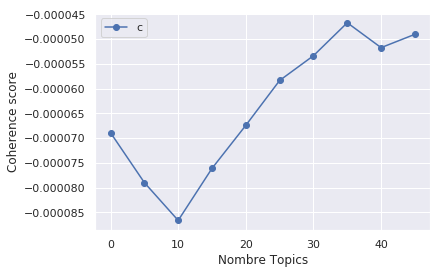

In [196]:
# Show graph
import seaborn as sns
sns.set(style="darkgrid")

limit=50; start=0; step=5;
x = range(start, limit, step)
plt.plot(x,np.array(coherence_values),marker="o")
plt.xlabel("Nombre Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [197]:
total_topics=best_model.n_components #recupere le nombre de topics du meilleurs modeles
weights = best_model.components_ #recuperes les poids du meilleurs modeles
# extract features and component weights
feature_names = tfidf.get_feature_names()

print("Le nombre de topic optimal est : ",total_topics)
print("*"*100)
topics = get_topics_terms_weights(weights,feature_names)
print_topics_udf(topics,total_topics,num_terms=15,display_weights=False)

Le nombre de topic optimal est :  36
****************************************************************************************************
Topic #1 without weights
['présumer affaire', 'implication présumer', 'implication', 'affaire', 'judiciaire', 'présumer', 'préfectoral police', 'an implication', 'service préfectoral', 'préfectoral', 'police judiciaire', 'individu', 'police', 'service', 'judiciaire casablancer']

Topic #2 without weights
['voici principal', 'titre développé', 'principal titre', 'développé presse', 'développé', 'presse', 'principal', 'voici', 'titre', 'presse national', 'septembr', 'national', 'presse quotidien', 'quotidien paraître', 'paraître']

Topic #3 without weights
['édition', 'festival', 'film', 'édition festival', 'festival international', 'international film', 'international', 'èm édition', 'cinéma', 'èm', 'rendre', 'soir', 'acteur', 'palais congrès', 'ocre']

Topic #4 without weights
['mort', 'blessé', 'accident', 'grièvement', 'blessé grièvement', 'circula

In [198]:
# Visualize the topics
pyLDAvis.sklearn.prepare(best_model,tfidf_train_features, tfidf, R=15)

/usr/local/lib/python3.5/dist-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/usr/local/lib/python3.5/dist-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/usr/local/lib/python3.5/dist-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/usr/local/lib/python3.5/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
11     5.319923        1       1 -0.108897  0.099500
10     4.995275        1       2  0.161317 -0.094102
12     4.939512        1       3 -0.295914 -0.088340
2      4.708224        1       4  0.076573 -0.111678
17     4.507963        1       5  0.074731  0.123800
0      4.184984        1       6 -0.337145 -0.072837
3      4.021608        1       7 -0.045555  0.149167
28     3.499057        1       8  0.094731 -0.060880
35     3.472987        1       9 -0.217495 -0.102275
4      3.341512        1      10  0.040576  0.109963
31     3.294064        1      11  0.097945 -0.016663
27     3.124796        1      12  0.063459  0.009773
6      3.117365        1      13 -0.206491 -0.035566
30     3.027437        1      14  0.089146 -0.073266
32     2.896860        1      15  0.062593 -0.021330
34     2.876553        1      16  0.005620  0.077786
16     2.780561        1      17  0.079061  0.111056
15     2.550703        1      18  0.045479  0.123055
9      2.474327        1      19  0.035689  0.063718
21     2.410622        1      20  0.076468  0.057235
25     2.313370        1      21  0.090035 -0.021985
1      2.266392        1      22 -0.023051  0.171530
26     2.165066        1      23  0.083188 -0.099988
22     2.146584        1      24  0.099912  0.034853
18     2.075097        1      25  0.064942  0.128900
5      2.071973        1      26  0.060840  0.012546
24     2.042059        1      27 -0.101612  0.026338
33     2.033192        1      28  0.097280 -0.136097
13     1.806341        1      29  0.124073 -0.134849
29     1.786833        1      30 -0.010981  0.152800
23     1.593216        1      31 -0.181025  0.052445
7      1.411081        1      32  0.030032 -0.118353
8      1.358916        1      33  0.023564  0.013046
19     1.347195        1      34 -0.263320 -0.028423
20     1.334281        1      35  0.063447 -0.233762
14     0.704070        1      36  0.050785 -0.067117, topic_info=     Category      Freq                        Term     Total  loglift  \
7599  Default  5.000000                       voici  5.000000  15.0000   
7157  Default  3.000000                       thème  3.000000  14.0000   
6611  Default  5.000000                     service  5.000000  13.0000   
6998  Default  2.000000     séminaire international  2.000000  12.0000   
3507  Default  2.000000         international thème  2.000000  11.0000   
...       ...       ...                         ...       ...      ...   
6531  Topic36  0.065647           science juridique  0.187516   3.9065   
6720  Topic36  0.065647            socio économique  0.187516   3.9065   
6372  Topic36  0.065647  régionalisation gouvernanc  0.187516   3.9065   
6537  Topic36  0.065647         scientifique ouvert  0.187516   3.9065   
3764  Topic36  0.065647                   juridique  0.187516   3.9065   

      logprob  
7599   15.000  
7157   14.000  
6611   13.000  
6998   12.000  
3507   11.000  
...       ...  
6531   -5.561  
6720   -5.561  
6372   -5.561  
6537   -5.561  
3764   -5.561  

[1060 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
30        7  0.927981              accident
32        7  0.960748  accident circulation
59       29  1.084027            accueillir
60       29  1.072280    accueillir congrès
76       24  0.848071           acquisition
...     ...       ...                   ...
7878     21  1.109406         état ministre
7879     11  0.821934          état réunion
7905     20  1.109649       évolution connu
7916     17  1.000853                 œuvre
7918     17  1.023405         œuvre sociale

[839 rows x 3 columns], R=15, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 11, 13, 3, 18, 1, 4, 29, 36, 5, 32, 28, 7, 31, 33, 35, 17, 16, 10, 22, 26, 2, 27, 23, 19, 6, 25, 34, 14, 30, 24, 8, 9, 20, 21, 15])

# Trouver le sujet dominant dans chaque document :
Pour trouver cela,il suffit de trouver le numéro de topic qui a le pourcentage de contribution le plus élevé dans ce document

In [257]:
def topic_dominant(model,tdidf_features,corpus,topics):
    
    #document topic distribution :la probabilité des topics pour chaque document
    doc_topic_dist = model.transform(tdidf_features) 
    
    topic_num=[] #liste qui contenir le numero du topic dominant dans chaque documents
    probs_topics=[] #liste qui va contenir les probabilités du topic dominant dans chaque documents
    topic_keywords=[] #liste qui contenir les 5 termes les plus representative du sujet
    text_doc=[] #liste qui va contenir le texte de chaque documents
    
    topic_terms=getTopicTerms(topics) #recupere les mot de chaque topics
    
    num_doc=[]
    
    for i,doc in enumerate(doc_topic_dist):
        text_doc.append(corpus[i]) #recupere le texte du documents
        num_doc.append(i+1) #recupere le numero du documents
        
        idx_max=doc.argmax() #recupere l'indice du topic qui a de la probabilité maximal
        topic_num.append(idx_max) 
        probs_topics.append(round(doc.max(),4)) #recupere la probabilité maximal arrondis
        
        kw=",".join(topic_terms[idx_max][:5]) #recupere les mots clé du topic
        topic_keywords.append(kw)
        
    
    sent_topics_df = pd.DataFrame([num_doc,topic_num,probs_topics,topic_keywords,text_doc]).T
    sent_topics_df.columns=["Num Document","Topic Dominant","Contrib Topic","Key Word","Text"]
    
    return sent_topics_df

In [258]:
sent_topics_df=topic_dominant(best_model,tfidf_train_features,corpus,topics)
sent_topics_df

,Num Document,Topic Dominant,Contrib Topic,Key Word,Text
0,1,28,0.0251,"culturel,culture,unesco,science culture,cultur...",cour constitutionnel jeudi verdict sujet révoc...
1,2,27,0.0542,"droit,droit humain,code,code pénal,réform",projet loi finance bel bien approuver deuxième...
2,3,32,0.8714,"politique,parti politique,parti,celle,demain soir",secrétaire général émission débat politique di...
3,4,32,0.8714,"politique,parti politique,parti,celle,demain soir",secrétaire général émission débat politique di...
4,5,32,0.079,"politique,parti politique,parti,celle,demain soir",tardivement soirée décembr secrétaire général ...
...,...,...,...,...,...
419,420,31,0.0274,"dialogue,groupe,dialogue stratégique,mercredi ...",comprendre raison motiver discours président t...
420,421,10,0.0409,"session,travail,èm,èm session,travail èm",troisième séance valeur modernisation dernier ...
421,422,32,0.0596,"politique,parti politique,parti,celle,demain soir",secrétaire général onu mardi décembre communau...
422,423,17,0.0259,"syndicat,dossier,directeur,education national,...",mouvement grèv continue jour mobilisation proj...


# Trouvez le document le plus représentatif pour chaque sujet :
Parfois, seuls les mots-clés du sujet peuvent ne pas être suffisants pour donner un sens au sujet d'un sujet. Donc, pour vous aider à comprendre le sujet, vous pouvez trouver les documents auxquels un sujet donné a le plus contribué et en déduire le sujet en lisant ce document

In [264]:
# Group top 5 sentences under each topic
sent_topics_sorted = pd.DataFrame()

sent_topics_outdf_grpd = df.groupby('Topic Dominant')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorted= pd.concat([sent_topics_sorted, grp.sort_values(['Contrib Topic'], ascending=[0]).head(1)], 
                                    axis=0)

# Reset Index    
sent_topics_sorted.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorted=sent_topics_sorted.drop(["Num Document"],axis=1)
# Show
sent_topics_sorted.head(15)

,Topic Dominant,Contrib Topic,Key Word,Text
0,0,0.5027,"présumer affaire,implication présumer,implicat...",service préfectoral police judiciaire casablan...
1,1,0.5411,"voici principal,titre développé,principal titr...",voici principal titre développé presse nationa...
2,2,0.1934,"édition,festival,film,édition festival,festiva...",cadre édition festival international film dern...
3,3,0.7781,"mort,blessé,accident,grièvement,blessé grièvement",total personne trouver mort autre blessé grièv...
4,4,0.6351,"météorologi,météorologi national,direction mét...",voici température minimal maximal prévoir dire...
5,5,0.7173,"adhérent,programme,formation,clôture programme...",centre formation fondation organiser samedi cé...
6,6,0.3802,"arm,police,arm service,aid,faire usage",brigadier police relever unité mobile motard p...
7,7,0.6944,"cœur prendre,prendre invité,gad cœur,invité ém...",gad cœur prendre invité émission
8,8,0.7084,"musée priver,enrichir,enrichir dimanche,musée,...",infrastructure enrichir dimanche inauguration ...
9,9,0.6294,"disparition feu,anniversaire disparition,dispa...",mohammed vendredi mausolée veillée religieux m...


In [ ]:
df=pd.read_csv("h24infos.csv")